In [1]:
import cProfile
import json

from pathlib import Path
import pandas as pd

In [2]:
import pstats
from openff.interchange.interop.internal import lammps


TAGS = (
    'mechanism',
    'polymer_name',
    'oligomer_size',
    'lattice_size',
    'MD_platform'
)
time_attr = 'cumtime'

p = Path('polymer_benchmark')
records = []
for path in p.glob('**/*.txt'):
    mol_dir = path.parents[1]
    mol_info = {
        tag : value
            for tag, value in zip(TAGS, path.relative_to(p).parts)
    }

    stats = pstats.Stats(str(path))
    stats = stats.sort_stats(pstats.SortKey.CUMULATIVE)
    stat_prof = stats.get_stats_profile()

    lmp_writer_times = {
        fn_name : getattr(fn_profile, time_attr)
            for fn_name, fn_profile in stat_prof.func_profiles.items()
                if ('_write' in fn_name) and (fn_profile.file_name == lammps.__file__)
    }
    mol_info.update(lmp_writer_times)
    
    record_path = mol_dir / f'{mol_info["lattice_size"]}_{mol_info["oligomer_size"]}_{mol_info["polymer_name"]}_RECORD.json'
    if record_path.exists:
        with record_path.open('r') as record_file:
            mol_info.update(json.load(record_file))

    records.append(mol_info)

pframe = pd.DataFrame.from_records(records)
pframe.set_index(['mechanism', 'polymer_name'], inplace=True)
# for str_path_col in ('profile_path', 'topology_path', 'interchange_path', 'directory'):
#     pframe[str_path_col] = pframe[str_path_col].map(Path) # de-stringify file Paths

print(len(pframe))
pframe

22


oligomer_size  \
mechanism               polymer_name                                                       
polyester               poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        trimer   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        trimer   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        trimer   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        trimer   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        trimer   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        trimer   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        trimer   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        trimer   
polyurethane_isocyanate poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        trimer   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        trimer   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        trimer   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        trimer   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        trimer   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        trimer   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        trimer   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        trimer   
polyamide               poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
                        poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
                        poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
                        poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
                        poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
                        poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   

                                                                           lattice_size  \
mechanism               polymer_name                                                      
polyester               poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        1x1x1   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        1x1x1   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        5x5x5   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        5x5x5   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        3x3x3   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        3x3x3   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        2x2x2   
                        poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...        2x2x2   
polyurethane_isocyanate poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        1x1x1   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        1x1x1   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        5x5x5   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        5x5x5   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        3x3x3   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        3x3x3   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        2x2x2   
                        poly(1,6-diisocyanatohexane-co-2-[2-[2-(2-hydro...        2x2x2   
polyamide               poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        1x1x1   
                        poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        1x1x1   
                        poly(4-[4-[6'-[4-(4-am

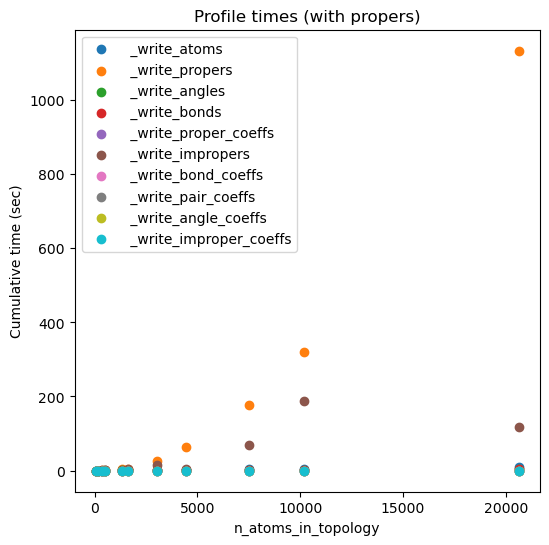

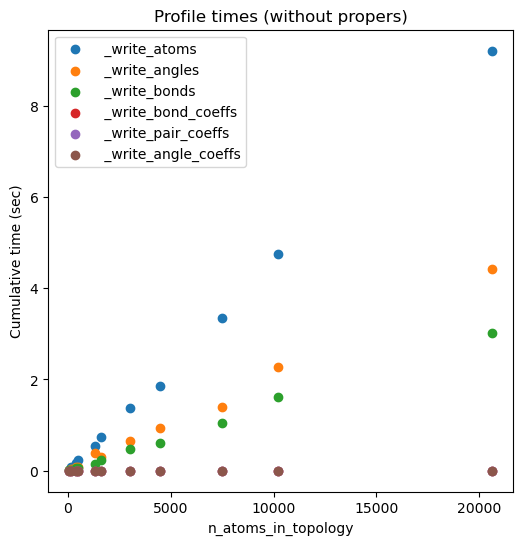

In [4]:
import matplotlib.pyplot as plt

dim = 6
n = pframe['n_atoms_in_topology']

for exclude_propers in (True, False):
    has_proper_str = f'with{"out" if not exclude_propers else ""}'

    fig, ax = plt.subplots(1, figsize=(dim, dim))
    for colname in pframe.columns:
        if ('_write' in colname) and (('proper' not in colname) or exclude_propers):
                ax.scatter(n, pframe[colname], label=' ' + colname, marker='o')
                
    ax.set_xlabel('n_atoms_in_topology')
    ax.set_ylabel('Cumulative time (sec)')
    ax.set_title(f'Profile times ({has_proper_str} propers)')

    leg = ax.legend(loc='best')
    fig.savefig(f'Cumultimes_{has_proper_str}_propers.png')

# Plotting Interchange output times for various MD platforms

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dim = 8
fig, ax = plt.subplots(figsize=(dim, dim))
inset_ax = inset_axes(ax, width='30%', height='30%', loc='upper left', bbox_to_anchor=(0.1,0.15,0.8,0.8), bbox_transform=ax.transAxes)

ax.scatter(pframe['n_atoms_in_topology'], pframe['lammps_time'], color='r', marker='o', label='to_lammps')
ax.scatter(pframe['n_atoms_in_topology'], pframe['openmm_time'], color='b', marker='o', label='to_openmm')
ax.set_xlabel('# atoms in topology')
ax.set_ylabel('Interchange output time (sec)')

small = pframe[pframe['lattice_size'] == '1x1x1']
inset_ax.set_title('single oligomers')
inset_ax.scatter(small['n_atoms_in_topology'], small['lammps_time'], color='r', marker='.', label='to_lammps')
inset_ax.scatter(small['n_atoms_in_topology'], small['openmm_time'], color='b', marker='.', label='to_openmm')
inset_ax.set_xlabel('# atoms')
inset_ax.set_ylabel('time (sec)')
ax.legend(loc='upper center')

fig.savefig('interchange_MD_benchmark.png')